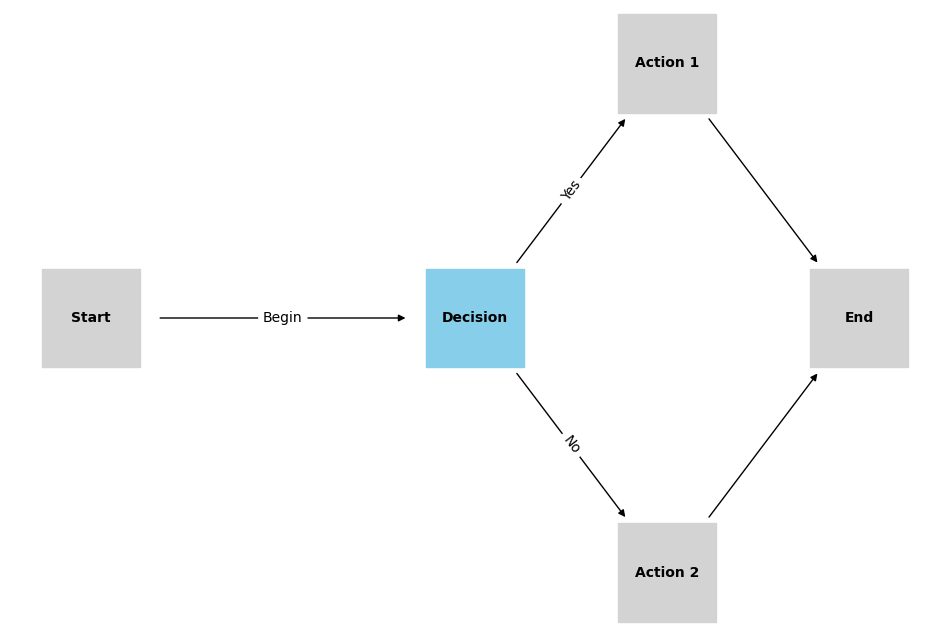

In [2]:
# Importing required libraries
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Adding nodes
G.add_nodes_from(["Start", "Decision", "Action 1", "Action 2", "End"])

# Adding edges
G.add_edges_from([("Start", "Decision"),
                  ("Decision", "Action 1"),
                  ("Decision", "Action 2"),
                  ("Action 1", "End"),
                  ("Action 2", "End")])

labels = {
    ("Start", "Decision"): "Begin",
    ("Decision", "Action 1"): "Yes",
    ("Decision", "Action 2"): "No",
    ("Action 1", "End"): "",
    ("Action 2", "End"): "",
}

node_colors = ['skyblue' if n == 'Decision' else 'lightgray' for n in G.nodes]

# nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=10, font_color='black', font_weight='bold', arrows=True)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Correcting the error and drawing the graph again with rounded corners for the rectangles

# Create a new figure and axis for larger size
fig, ax = plt.subplots(figsize=(12, 8))

pos = {
    "Start": (0, 2),
    "Decision": (1, 2),
    "Action 1": (1.5, 3),
    "Action 2": (1.5, 1),
    "End": (2, 2)
}

# Draw nodes
# nx.draw_networkx_nodes(G, custom_pos, node_color=node_colors, node_size=4000, linewidths=2)

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=5000, font_size=10, font_color='black', font_weight='bold', node_shape='s', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [3]:
from sweepai.core.entities import FileChangeRequest

first_check = FileChangeRequest(
    filename="a.py", 
    instructions="Write unit tests",
    change_type="check"
)

file_change_requests = [
    FileChangeRequest(
        filename="a_test.py", 
        instructions="Write unit tests",
        change_type="modify"
    ),
    first_check,
    FileChangeRequest(
        filename="a.py", 
        instructions="Fix failed unit test",
        change_type="modify",
        parent=first_check
    ),
    FileChangeRequest(
        filename="a_test.py", 
        instructions="Fix failed unit test",
        change_type="check",
        parent=first_check
    ),
]

print(file_change_requests)

2023-10-19 13:03:00.042 | INFO     | sweepai.config.server:<module>:195 - Using Sandbox URL: http://0.0.0.0:8081


[FileChangeRequest(filename='a_test.py', instructions='Write unit tests', change_type='modify', entity=None, new_content=None, raw_relevant_files=None, start_and_end_lines=[], comment_line=None, failed_sandbox_test=False, parent=None), FileChangeRequest(filename='a.py', instructions='Write unit tests', change_type='check', entity=None, new_content=None, raw_relevant_files=None, start_and_end_lines=[], comment_line=None, failed_sandbox_test=False, parent=None), FileChangeRequest(filename='a.py', instructions='Fix failed unit test', change_type='modify', entity=None, new_content=None, raw_relevant_files=None, start_and_end_lines=[], comment_line=None, failed_sandbox_test=False, parent=FileChangeRequest(filename='a.py', instructions='Write unit tests', change_type='check', entity=None, new_content=None, raw_relevant_files=None, start_and_end_lines=[], comment_line=None, failed_sandbox_test=False, parent=None)), FileChangeRequest(filename='a_test.py', instructions='Fix failed unit test', c

ValueError: 'c' argument has 5 elements, which is inconsistent with 'x' and 'y' with size 6.

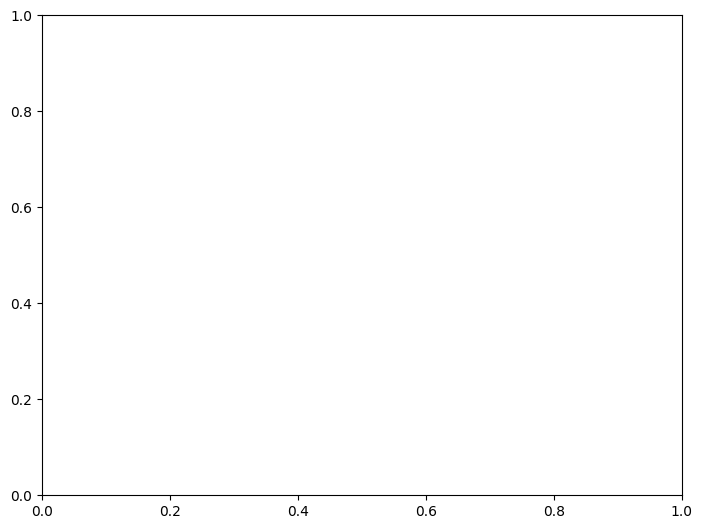

In [7]:
G = nx.DiGraph()

for i, file_change_request in enumerate(file_change_requests):
    G.add_node(file_change_request.entity_display, label=i)

for i, file_change_request in enumerate(file_change_requests):
    from_index = file_change_requests.index(file_change_request)
    G.add_edge(from_index, i)

# G.add_edges_from([])

pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=5000, font_size=10, font_color='black', font_weight='bold', node_shape='s', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()